In [41]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan, bulk
from time import time, strftime, localtime, sleep
from datetime import datetime, timedelta
from itertools import islice
import pickle
import numpy as np
import pandas as pd
import json
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.axes as ax

# import cufflinks as cf
import plotly as py
import plotly.graph_objects as go

import seaborn as sns
%matplotlib inline

user = None
passwd = None
if user is None and passwd is None:
    with open("creds.key") as f:
        user = f.readline().strip()
        passwd = f.readline().strip()
credentials = (user, passwd)
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=240, http_auth=credentials)

print("Connection Successful") if es.ping() == True else print("Connection Unsuccessful")



Connection Successful


In [2]:
# All data  (GMT): Monday, January 12, 2020 3:52:49 -> January 13, 2020 15:52:49 
query = {
    "size": 5,
  "query": {
    "bool":{
      "must":[
        {
          "range": {
            "timestamp": {
              "gte": "1578844369000",
              "lt": "1578930769000" 
            }
          }
        }
      ]
    }
  }
}

    
data = scan(es, index="ps_packetloss", query=query)
#data = es.search("ps_packetloss", body=query)

res = []
temp = []
i = 0
for d in data:
    res.append(d['_source'])
    #print(d)
    if i % 100000 == 0:
        print("next 100K",i)
#     if i == 100000:
#         break
    i = i + 1


next 100K 0
next 100K 100000
next 100K 200000
next 100K 300000
next 100K 400000
next 100K 500000
next 100K 600000
next 100K 700000
next 100K 800000
next 100K 900000
next 100K 1000000
next 100K 1100000
next 100K 1200000
next 100K 1300000
next 100K 1400000
next 100K 1500000
next 100K 1600000
next 100K 1700000
next 100K 1800000
next 100K 1900000
next 100K 2000000
next 100K 2100000
next 100K 2200000
next 100K 2300000
next 100K 2400000
next 100K 2500000
next 100K 2600000
next 100K 2700000
next 100K 2800000
next 100K 2900000
next 100K 3000000
next 100K 3100000
next 100K 3200000
next 100K 3300000
next 100K 3400000
next 100K 3500000
next 100K 3600000
next 100K 3700000
next 100K 3800000
next 100K 3900000
next 100K 4000000
next 100K 4100000
next 100K 4200000
next 100K 4300000
next 100K 4400000
next 100K 4500000
next 100K 4600000
next 100K 4700000
next 100K 4800000
next 100K 4900000
next 100K 5000000
next 100K 5100000
next 100K 5200000
next 100K 5300000
next 100K 5400000
next 100K 5500000
next 10

In [3]:
dfr = pd.DataFrame(res)

In [4]:
dfr['dt'] = pd.to_datetime(dfr['timestamp'], unit='ms')
agg_data = (dfr.groupby(['src_VO', 'src_site', 'src_host', 'src', 'dest_VO', 'dest_site', 'dest_host', 'dest', 
                         pd.Grouper(key='dt', freq='1h')]).agg({'packet_loss':'mean'}))

In [5]:
agg_data.head(3)

packet_loss
src_VO src_site  src_host       src             dest_VO dest_site dest_host                dest          dt                              
       FI_HIP_T2 pship01.csc.fi 109.105.125.232         GLOW      perfsonar01.hep.wisc.edu 144.92.180.75 2020-01-12 15:00:00     0.000000
                                                                                                         2020-01-12 16:00:00     0.000028
                                                                                                         2020-01-12 17:00:00     0.000053

In [6]:
ip_table = pd.pivot_table(agg_data, values='packet_loss', index=['src'], columns=['dest'], aggfunc=[np.mean])
host_table = pd.pivot_table(agg_data, values='packet_loss', index=['src_host'], columns=['dest_host'], aggfunc=[np.mean])
site_table = pd.pivot_table(agg_data, values='packet_loss', index=['src_site'], columns=['dest_site'], aggfunc=[np.mean])

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_ipt = scaler.fit_transform(ip_table.values)
scaled_ht = scaler.fit_transform(host_table.values)
scaled_st = scaler.fit_transform(site_table.values)

In [42]:
# Contruct an inteactive heatmap with Plotly
def buildFig(df, scaled_vals, period, x_title, y_title):
    fig = go.Figure(go.Heatmap(
        x=df.columns.levels[1],
        y=df.index,
        z=scaled_vals,
        hovertext=df.values,
        colorscale='algae'
    ))

    fig.update_layout(
        title='Avg Packet Loss for '+period,
        xaxis = {
                 'title': x_title, 
                 'type': 'category'
                 },
        yaxis = {
                'title': y_title,
                'type': 'category',
                },
        font=dict(size=9),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)')
    py.offline.plot(fig)

In [43]:
# Crete the plots offline. Look for a temp.plot.html file
buildFig(ip_table, scaled_ipt, '12-13 Jan 2020', 'Destination IP', 'Source IP')

In [ ]:
buildFig(host_table, scaled_ht, '12-13 Jan 2020', 'Destination host', 'Source host')

In [44]:
buildFig(site_table, scaled_st, '12-13 Jan 2020', 'Destination site', 'Source site')

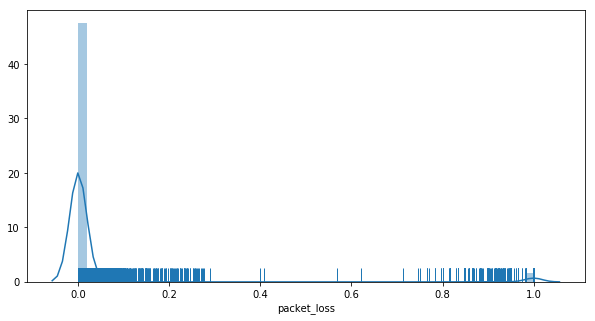

In [28]:
# Get value distribution plot
plt.figure(figsize=(10,5))
sns.distplot(agg_data['packet_loss'], rug=True);

In [ ]:
# Unpivot data
unp_data = agg_data.copy()
unp_data.reset_index(inplace=True)

In [29]:
# See what is the most common range of loss in % for all test entries
zeros = unp_data[unp_data['packet_loss'] == 0].count(axis=1).sum()
zero0 = unp_data[(unp_data['packet_loss'] > 0) & (unp_data['packet_loss'] <= 0.05)].count(axis=1).sum()
zero1 = unp_data[(unp_data['packet_loss'] > 0.05) & (unp_data['packet_loss'] <= 0.1)].count(axis=1).sum()
zero2 = unp_data[(unp_data['packet_loss'] > 0.1) & (unp_data['packet_loss'] <= 0.3)].count(axis=1).sum()
zero3 = unp_data[(unp_data['packet_loss'] > 0.3) & (unp_data['packet_loss'] <= 0.9)].count(axis=1).sum()
zero4 = unp_data[(unp_data['packet_loss'] > 0.9) & (unp_data['packet_loss'] < 1)].count(axis=1).sum()
ones = unp_data[(unp_data['packet_loss'] == 1)].count(axis=1).sum()

todf = pd.DataFrame(columns=['Percetage', 'Value'])
todf['Percetage'] = ['0%', '0-5%', '5-10%', '10%-30%', '30%-90%', '90%-100%','100%']
todf['Value'] = [zeros, zero0, zero1, zero2, zero3, zero4, ones]

todf

,Percetage,Value
0,0%,474550
1,0-5%,421070
2,5-10%,6030
3,10%-30%,1380
4,30%-90%,1520
5,90%-100%,2020
6,100%,30920


Text(0, 0.5, 'Counted by Src-Dest pair')

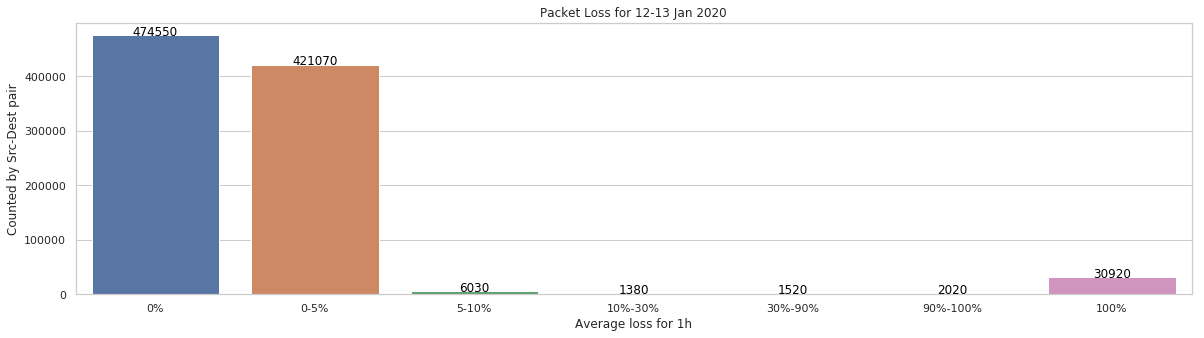

In [31]:
# Build a barplot based on the above
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.barplot(x=todf['Percetage'], y=todf['Value'], data=todf)
for index, row in todf.iterrows():
    ax.text(row.name,row.Value, row.Value, color='black', ha="center")
    
plt.title('Packet Loss for 12-13 Jan 2020')
plt.xlabel('Average loss for 1h')
plt.ylabel('Counted by Src-Dest pair')

In [32]:
# Agregate data by src-dest IPs and get the mean loss

loss = unp_data.groupby(['src', 'dest'])['src', 'dest', 'packet_loss'].mean()
loss[loss['packet_loss'] < 1].head()

packet_loss
src            dest                       
109.105.124.86 129.107.255.29     0.000001
               129.15.40.231      0.000001
               130.246.47.129     0.000057
               134.219.225.13     0.000002
               134.79.118.72      0.000000

In [33]:
# See what is the most common range of loss in % for all test entries

zeros = loss[loss['packet_loss'] == 0].count(axis=1).sum()
zero0 = loss[(loss['packet_loss'] > 0) & (loss['packet_loss'] <= 0.05)].count(axis=1).sum()
zero1 = loss[(loss['packet_loss'] > 0.05) & (loss['packet_loss'] <= 0.1)].count(axis=1).sum()
zero2 = loss[(loss['packet_loss'] > 0.1) & (loss['packet_loss'] <= 0.3)].count(axis=1).sum()
zero3 = loss[(loss['packet_loss'] > 0.3) & (loss['packet_loss'] <= 0.9)].count(axis=1).sum()
zero4 = loss[(loss['packet_loss'] > 0.9) & (loss['packet_loss'] < 1)].count(axis=1).sum()
ones = loss[(loss['packet_loss'] == 1)].count(axis=1).sum()

todf1 = pd.DataFrame(columns=['Percetage', 'Value'])
todf1['Percetage'] = ['0%', '0-5%', '5-10%', '10%-30%', '30%-90%', '90%-100%','100%']
todf1['Value'] = [zeros, zero0, zero1, zero2, zero3, zero4, ones]

Text(0, 0.5, 'Grouped by Src-Dest')

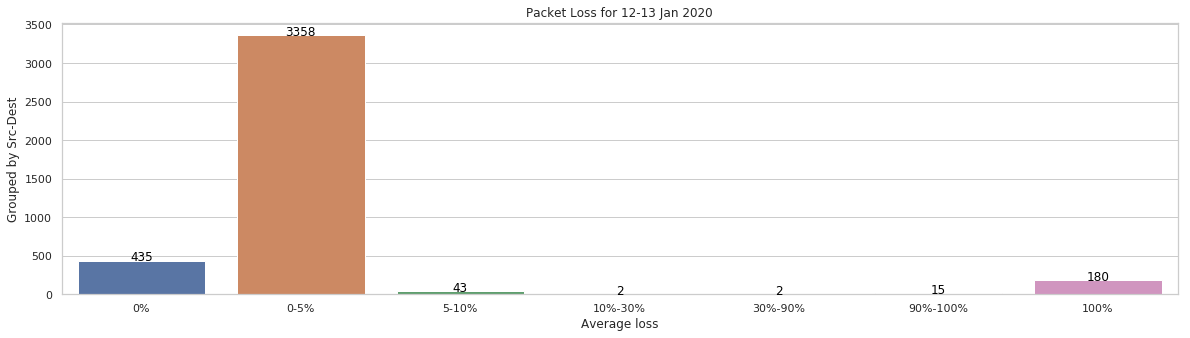

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.barplot(x=todf1['Percetage'], y=todf1['Value'], data=todf1)
for index, row in todf1.iterrows():
    ax.text(row.name,row.Value, row.Value, color='black', ha="center")
    
plt.title('Packet Loss for 12-13 Jan 2020')
plt.xlabel('Average loss')
plt.ylabel('Grouped by Src-Dest')